### Importation de Bibliothèques 

In [1]:
import os
import sys 
sys.path.append('/home/onyxia/work/libsigma')
# Personal librairies
import read_and_write as rw
import classification as cla
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal

### Définition des chemins de jeux de données 

In [2]:
my_folder = '/home/onyxia/work/Depot_Git/results/data'
in_vector = os.path.join(my_folder, 'sample/Sample_BD_foret_T31TCJ.shp')
ref_image = os.path.join(my_folder, 'img_pretraitees/Serie_temp_S2_ndvi.tif')
out_image = os.path.splitext(in_vector)[0] + '_v2.tif'
field_name = "Code"  

In [4]:
# Extraction des caractéristiques de la couche raster de NDVI 
data_set = rw.open_image(ref_image)
nb_lignes, nb_col, nb_band = rw.get_image_dimension(data_set)
print (nb_lignes)
print(nb_col)
print(nb_band)
origin_x, origin_y = rw.get_origin_coordinates(data_set)
pixel_size = rw.get_pixel_size(data_set)
def get_raster_bounds(data_set):
    geotransform = data_set.GetGeoTransform()
    origin_x, origin_y = geotransform[0], geotransform[3]
    pixel_size_x, pixel_size_y = geotransform[1], geotransform[5]
    raster_x_size = data_set.RasterXSize
    raster_y_size = data_set.RasterYSize

    xmin = origin_x
    xmax = origin_x + raster_x_size * pixel_size_x
    ymax = origin_y
    ymin = origin_y + raster_y_size * pixel_size_y

    print(f"xmin: {xmin}, ymin: {ymin}, xmax: {xmax}, ymax: {ymax}")
    print(f"Spatial resolution: ({abs(pixel_size_x)}, {abs(pixel_size_y)})")
    
    return xmin, ymin, xmax, ymax, (abs(pixel_size_x), abs(pixel_size_y))
xmin, ymin, xmax, ymax, spatial_resolution = get_raster_bounds(data_set)

7381
10863
6
xmin: 501127.9696999999, ymin: 6240654.023599998, xmax: 609757.9696999999, ymax: 6314464.023599998
Spatial resolution: (10.0, 10.0)


/opt/conda/lib/python3.12/site-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [5]:
# Rastérisation de la couche vecteur des échantillons 
sptial_resolution = 10
xmin = 501127.9696999999
ymin = 6240654.023599998
xmax = 609757.9696999999
ymax = 6314464.023599998

# define command pattern to fill with paremeters
cmd_pattern = ("gdal_rasterize -a {field_name} "
               "-tr {sptial_resolution} {sptial_resolution} "
               "-te {xmin} {ymin} {xmax} {ymax} -ot Byte -of GTiff "
               "{in_vector} {out_image}")

# fill the string with the parameter thanks to format function
cmd = cmd_pattern.format(in_vector=in_vector, xmin=xmin, ymin=ymin, xmax=xmax,
                         ymax=ymax, out_image=out_image, field_name=field_name,
                         sptial_resolution=sptial_resolution)

# execute the command in the terminal
os.system(cmd)

0...10...20...30...40...50...60...70...80...90...100 - done.


0

### Extraction de classes  à partir de fichier des échantillons et des valeurs de pixels à partir de raster de NDVI 

In [6]:
my_folder = '/home/onyxia/work/Depot_Git/results/data'
sample_filename = os.path.join(my_folder, 'sample/Sample_BD_foret_T31TCJ_v2.tif')
image_filename = os.path.join(my_folder, 'img_pretraitees/Serie_temp_S2_ndvi.tif')
X, Y, t = cla.get_samples_from_roi(image_filename, sample_filename)
print(X.shape)
print(Y.shape)
# Vérification de valeur min et max de NDVI 
min_X = X.min()
max_X = X.max()  
print(f"Valeur minimale  de X: {min_X}")
print(f"Valeur maximale de X: {max_X}")

# Vérifiaction s'il y a des valeur de NDVI en dehors de l'intervalle [-1,1]
out_of_range = X[(X < -1) | (X > 1)] 
if len(out_of_range) > 0:
    print(f"valeurs de NDVI en dehors de l'intervalle [-1,1] : {out_of_range}")
else:
    print("Pas de valeur de NDVI en dehors de l'intervalle [-1,1]")

(4997108, 6)
(4997108, 1)
Valeur minimale  de X: 0.0
Valeur maximale de X: 1129.82763671875
valeurs de NDVI en dehors de l'intervalle [-1,1] : [ 75.24856  97.58122 234.85663 ... 137.10042 189.28323 209.3067 ]


In [7]:
# Convertion de matrice de label dans la bonne format 
Y = Y.flatten()  # Convertion Y de (4997108, 1) à (4997108,)

# Vérification de la taille de matrice de labels et la matrice des valeurs de NDVI pour le six dates 
print(X.shape)  # (4997108, 6)
print(Y.shape)  # (4997108,)

# list de codes de classes d'intérêt 
codes_of_interest = ['12', '13', '14', '23', '24', '25']

# Filtrage pour ne garder que les pixels dnt la code de la classe est inclu dans la liste de codes d'intérêt
mask = np.isin(Y.astype(str), codes_of_interest) 

X_filtered = X[mask]  
Y_filtered = Y[mask] 

# Vérification de résultat de filtrage appliqué
print("Shape de X_filtered:", X_filtered.shape)
print("Shape de Y_filtered:", Y_filtered.shape)

# Vérification des classes présentes après filtrage 
unique_classes_in_y = np.unique(Y_filtered)
print(f"Classes uniques : {unique_classes_in_y}")

(4997108, 6)
(4997108,)
Shape de X_filtered: (2387823, 6)
Shape de Y_filtered: (2387823,)
Classes uniques : [12 13 14 23 24 25]


### Visualisation graphique de l'évolution de signature Spectrale de moyenne et l'écart-type par classe en fonction de dates  

Classe 12: 0 instances trouvées
Classe 13: 0 instances trouvées
Classe 14: 0 instances trouvées
Classe 23: 0 instances trouvées
Classe 24: 0 instances trouvées
Classe 25: 0 instances trouvées


/tmp/ipykernel_20748/3424651926.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Classes", loc='upper left')


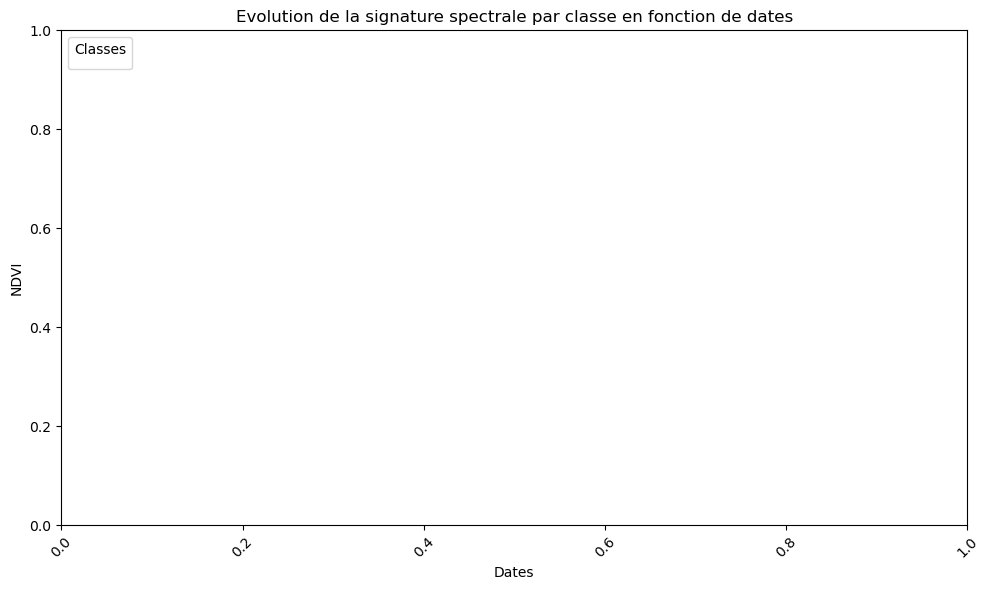

In [8]:
# Liste de dates
dates = ['2023-01-01', '2023-03-01', '2023-05-01', '2023-07-01', '2023-09-01', '2023-11-01']
# Couleurs choisies pour chaque classe
colors = ['tan', 'palegreen', 'limegreen', 'darkgreen', 'lightblue', 'orange']
# Liste de Labels
class_names = ['Chêne', 'Robinier', 'Peupleraie', 'Douglas', 'Pin_laricio_ou_pin_noir', 'Pin_maritime']

# Préparation de la fenêtre graphique
fig, ax = plt.subplots(figsize=(10, 6))

# Parcourir les classes
for idx, code in enumerate(codes_of_interest):
    # Vérifier les données pour chaque classe
    X_class = X_filtered[Y_filtered == code]
    print(f"Classe {code}: {X_class.shape[0]} instances trouvées")

    if X_class.shape[0] > 0:
        # Calculer moyenne et écart-type
        means = X_class.mean(axis=0)
        stds = X_class.std(axis=0)

        # Vérifier les valeurs calculées
        print(f"Classe {code}: Moyennes {means}, Écart-types {stds}")

        # Vérification des indices
        assert idx < len(colors), f"Indice {idx} dépasse la taille de 'colors'"
        assert idx < len(class_names), f"Indice {idx} dépasse la taille de 'class_names'"

        # Tracer les moyennes et intervalles
        ax.plot(dates, means, color=colors[idx], label=class_names[idx])
        ax.fill_between(dates, means - stds, means + stds, color=colors[idx], alpha=0.3)

# Configurer les étiquettes et le graphique
ax.set_xlabel('Dates')
ax.set_ylabel('NDVI')
ax.set_title('Evolution de la signature spectrale par classe en fonction de dates')

# Supprimer temporairement la limite pour tester
ax.set_ylim(None)

ax.legend(title="Classes", loc='upper left')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
